# Simple Training

Train a single variable to discriminate between input and outputs using the scikit-learn simple NN's

## Settings

In [ ]:
n_variables = 4 # Number of data and background varialbes to generate
n_samples = 10000 # Number of samples to generate

center_signal = 2.0 # Where the gaussian for signal should be
center_background = 1.0 # Where the gaussian for background should be

In [2]:
import sys
sys.path += ['../abcdlib']
import data_gen

import seaborn as sns
import pandas as pd
from torch import nn
from torch import optim
import torch
import torch.nn.functional as nnf

## Generate the data

In [3]:
sig = data_gen.generate_gaussian(n_variables, center_signal, n_samples)
back = data_gen.generate_gaussian(n_variables, center_background, n_samples)

half = int(n_samples/2)

training = data_gen.combine(sig[:half], back[:half])
testing = data_gen.combine(sig[half:], back[half:])

## Train with one output

First, prepare the data for fitting. PyTorch works funny - though this is probably the way things really work under the covers - I'm just not used to it. Basically, the output of the network needs to be 1 _column_ per class. We have 2 classes here: signal and background. When we build the model below, you'll see 2 outputs, and then a SoftMax in order to normalize them (and make sure they don't total more than 1). However, the `NLLLoss` function takes a single vector with the class number as the labels. Hence, the `y_train` is a single column with a 0 (background) or a 1 (signal) in it.

In [4]:
x_train = torch.Tensor(training[training.columns[:-1]].values)
y_train = torch.Tensor(training[training.columns[-1]].values).type(torch.LongTensor)

Next create a simple classifier - 2 layers, with the same number of nodes as inputs

In [10]:
model = nn.Sequential(nn.Linear(n_variables, n_variables),
                      nn.ReLU(),
                      nn.Linear(n_variables, n_variables),
                      nn.ReLU(),
                      nn.Linear(n_variables, 2),
                      nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.03)

Now lets do the training

In [11]:
epochs = 1000
for e in range(epochs):
    running_loss = 0
    optimizer.zero_grad()
    output = model(x_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
else:
    print(f'Training loss: {running_loss/len(x_train)}')

Training loss: 3.7572997808456423e-05


## Prediction

Get the predicted probabilities out and see where they line up and how well this guy did!

In [12]:
x_test = torch.Tensor(testing[testing.columns[:-1]].values)
y_test = model(x_test)

In [13]:
r = nnf.softmax(y_test, dim=1).detach().numpy()
x_results = testing.copy()
x_results['Prediction'] = r[:,1]

<AxesSubplot:xlabel='Prediction', ylabel='Count'>

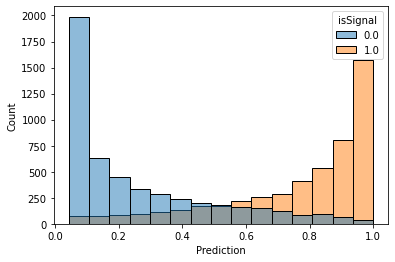

In [14]:
sns.histplot(x_results, x='Prediction', hue='isSignal')